In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from osgeo import gdal

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

In [6]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

path = "E:\\UNet\\Tiles\\Merge" 
images = sorted(glob(os.path.join(path, "image/*")))
masks = sorted(glob(os.path.join(path, "mask/*")))

minx = -70
maxx = 70

a = images[1]
b = gdal.Open(a).ReadAsArray()
c = np.rollaxis(b, 0, 3)
d = (c - minx) / (maxx - minx)

e = masks[1]
f = gdal.Open(e).ReadAsArray()
g = np.expand_dims(f, axis=2)
g.shape
#h = (g - minx) / (maxx - minx)


(128, 128, 1)

In [7]:

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "image/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [8]:
def read_image(path):
    path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    x = np.rollaxis(x, 0, 3)
    x = (x - minx) / (maxx - minx)
    x = x.astype(np.float32)
    return x

In [9]:
def read_mask(path):
    path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    #x = np.rollaxis(x, 0, 3)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

In [10]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([128, 128, 5])
    y.set_shape([128, 128, 1])
    return x, y

In [11]:
def tf_dataset(x, y, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input((size, size, 5))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


In [13]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [14]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [15]:
if __name__ == "__main__":
    ## Dataset
    path = "E:\\UNet\\Tiles\\Merge" 
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [16]:
batch = 32
epochs = 100

In [17]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)
print(train_dataset)
print(valid_dataset)


<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [18]:
model = build_model()
opt = tf.keras.optimizers.Adam()
metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [19]:
callbacks = [
    ModelCheckpoint("files/model.h5"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    #CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [20]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [21]:
history = model.fit(train_dataset,
          validation_data=valid_dataset,
          epochs=epochs,
          steps_per_epoch=train_steps,
          validation_steps=valid_steps,
          callbacks=callbacks)

Epoch 1/100
11/11 [==============================] - 12s 535ms/step - loss: 0.3764 - accuracy: 0.8650 - recall: 0.6799 - precision: 0.8952 - iou: 0.4087 - val_loss: 0.6554 - val_accuracy: 0.7823 - val_recall: 0.4925 - val_precision: 0.6607 - val_iou: 0.2396 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 1s 121ms/step - loss: 0.2584 - accuracy: 0.9421 - recall: 0.9382 - precision: 0.8954 - iou: 0.5284 - val_loss: 0.5855 - val_accuracy: 0.8124 - val_recall: 0.5532 - val_precision: 0.7262 - val_iou: 0.2685 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 1s 121ms/step - loss: 0.2373 - accuracy: 0.9461 - recall: 0.9473 - precision: 0.8986 - iou: 0.5567 - val_loss: 0.5327 - val_accuracy: 0.8035 - val_recall: 0.8625 - val_precision: 0.6111 - val_iou: 0.3458 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 1s 121ms/step - loss: 0.2208 - accuracy: 0.9508 - recall: 0.9492 - precision: 0.9091 - iou: 0.5811 - val_loss: 0.4568 - val_accuracy: 0.

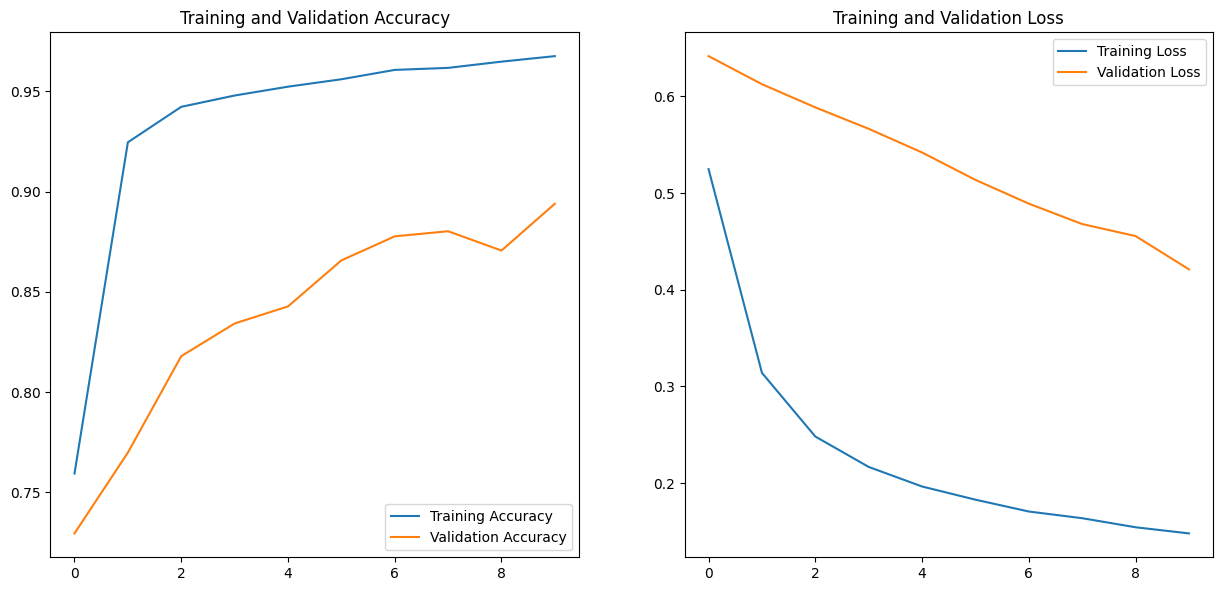

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(44)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm

In [23]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [24]:
model.save("unet_test2.h5")

In [25]:
batch_size = 32
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
 
test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [26]:
model.evaluate(test_dataset, steps=test_steps)

2/2 [==============================] - 1s 142ms/step - loss: 0.4635 - accuracy: 0.8718 - recall: 0.9909 - precision: 0.6960 - iou: 0.4603


[0.46349334716796875,
 0.8717753291130066,
 0.9908581972122192,
 0.6959728002548218,
 0.4603223502635956]

In [78]:
def read_image2(path):
    #path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    #x = np.rollaxis(x, 0, 2)
    x = np.expand_dims(x,axis=-1)
    #x = x/65535
    x = x.astype(np.float32)
    return x


def read_mask2(path):
    #path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    #x = np.rollaxis(x, 0, 2)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

In [79]:
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    x = read_image2(x)
    y = read_mask2(y)
    y_pred = model.predict(np.expand_dims(x, axis=-1))[0] > 0.9
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255.0
    all_images = [
        x * 255.0, white_line,
        mask_parse(y_pred) * 255.0
    ]
    image = np.concatenate(all_images, axis=1)
    cv2.imwrite(f"results/{i}.png", image)

  0%|                                                                                           | 0/42 [00:00<?, ?it/s]

(5, 128, 128, 1)


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model/conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_predict_function_15160]

In [40]:
import os, os.path
imgs = []
path2 = "F:\\Citra\\UNet\\Test"
valid_images = [".tif"]
for f in os.listdir(path2):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(os.path.join(path2,f))
imgs

['F:\\Citra\\UNet\\Test\\1_s22_training__1020_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1021_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1022_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1023_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1024_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1028_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1029_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1030_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1031_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1032_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1033_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1034_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1035_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1036_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1037_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1038_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1039_128.tif',
 'F:\\Citra\\UNet\\Test\\1_s22_training__1040_12

In [41]:
path3 = "I:\\UNet\\Tiles_NDVI\\Merge\\NG04"
model = keras.models.load_model("unet_deforestation.h5")
for k in tqdm(imgs):
    test = read_image2(k)
    name = k.split ("\\") [- 1] .split (".") [0]
    y_pred = model.predict(np.expand_dims(test, axis=1))[0] > 0.90
    h, w, _ = test.shape
    white_line = np.ones((h, 10, 3)) * 255.0
    all_images = y_pred * 255.0
    #all_images = [
        #mask_parse(y_pred) * 255.0
    #]
    image = np.concatenate(all_images, axis=1)
    cv2.imwrite(os.path.join(path3, f"{name}_ps.png"), image)

100%|██████████████████████████████████████████████████████████████████████████████| 4517/4517 [03:25<00:00, 21.95it/s]


In [ ]:
import imutils
import cv2
import numpy as np
from tensorflow.keras.utils import normalize
from matplotlib import pyplot as plt

In [ ]:
def prediction(model, image, patch_size):
    segm_img = np.zeros(image.shape[:2])  #Array with zeros to be filled with segmented values
    patch_num=1
    for i in range(0, image.shape[0], 128):   #Steps of 256
        for j in range(0, image.shape[1], 128):  #Steps of 256
            #print(i, j)
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch = np.array(single_patch)
            if single_patch.shape[1] != 128 or single_patch.shape[1] != 128:
                pass
                #single_patch = single_patch.resize(128, 128)
                #single_patch[np.isnan(single_patch)] = 0
                #single_patch_norm = np.expand_dims(single_patch, axis=-1)
                #single_patch_shape = single_patch_norm.shape[:2]
                #single_patch_input = (np.expand_dims(single_patch_norm, 0))/65535
                #single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
                #segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
          
                #print("Finished processing patch number ", patch_num, " at position ", i,j)
                #patch_num+=1
            else:
                single_patch_norm = np.expand_dims(single_patch, axis=-1)
                single_patch_shape = single_patch_norm.shape[:2]
                single_patch_input = (np.expand_dims(single_patch_norm, 0))/65535
                single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
                segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
          
                print("Finished processing patch number ", patch_num, " at position ", i,j)
                patch_num+=1
        return segm_img

In [ ]:
from osgeo import gdal
patch_size = 128
large_image = gdal.Open('data/CAPELLA_C02_SP_GEO_REPRO_HH_20210113201240_20210113201307.tif').ReadAsArray()
#large_image[np.isnan(large_image)] = 0
print(large_image.shape)
print(np.expand_dims(np.array(large_image), axis=-1).shape)
segmented_image = prediction(model, large_image, patch_size)

In [ ]:
#plt.hist(segmented_image.flatten())  #Threshold everything above 0

plt.imsave('data/segm.jpg', segmented_image, cmap='gray')